In [ ]:
import time

start_time = time.time()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn 
import imblearn
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, balanced_accuracy_score, precision_recall_fscore_support, roc_auc_score

from sklearn.feature_selection import SelectFromModel

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [ ]:
#Ignorando avisos
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Formatação
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold= 15)
np.set_printoptions(precision=3)
sns.set(style="darkgrid")
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

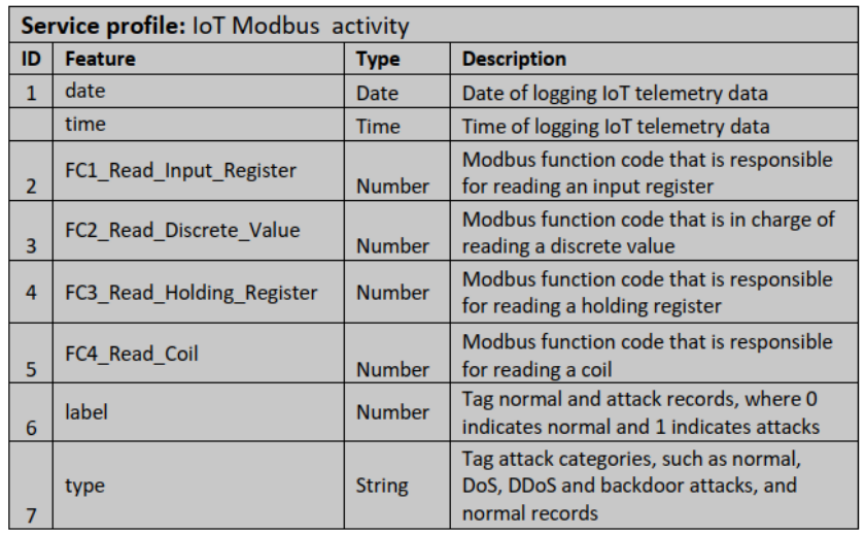

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Carregue seus dados do dispositivo 3 em um dataframe pandas
df = pd.read_csv('Train_Test_IoT_Modbus.csv')
df

In [ ]:
df['time'].value_counts()

In [ ]:
# Substituindo os espaços em branco na coluna 'time'
df['time'] = df['time'].str.replace(' ', '')

In [ ]:
df['time'].value_counts()

In [ ]:
df['hour'] = ''
df['minute'] = ''
df['second'] = ''

In [ ]:
df.head()

In [ ]:
df[['hour', 'minute', 'second']] = df['time'].str.split(':', expand=True)

In [ ]:
df['hour'] = df['hour'].astype(int)
df['minute'] = df['minute'].astype(int)
df['second'] = df['second'].astype(int)

In [ ]:
df.head()

## Ajuste do conjunto de dados

In [ ]:
# Teste sem a feature de TS. 
df.drop(['ts', 'type', 'time'], axis=1, inplace=True)

# Criando outras features usando a data (day-month-year)
df.date = pd.to_datetime(df.date)
df['day'] = df.date.dt.day
df['month'] = df.date.dt.month
df['year'] = df.date.dt.year

df.drop(labels=['date'], inplace=True, axis=1)
df.head()

## Divisão dos Dados

In [ ]:
# DIVISÃO DOS DADOS DE TREINO E TESTE
X_train, X_test, y_train, y_test = train_test_split(df[['FC1_Read_Input_Register', 'FC2_Read_Discrete_Value', 'FC3_Read_Holding_Register',
                                                        'FC4_Read_Coil','day', 'hour', 'minute', 'second']], df['label'], 
                                                    test_size=0.2, random_state=42)


## Pre-pocessamento

In [ ]:
categorical_features = []
cat_handle = ColumnTransformer(
                    transformers=[
                        ('cat', OrdinalEncoder(), categorical_features),
                         ], remainder='passthrough')

# Juntamos tudo; Lidando com os dados categoricos e em seguida fazendo o standardscaler
preprocessor = Pipeline(steps=[
    ('categorical', cat_handle), 
    ('numerical', StandardScaler())
])

## Regressão Logística - Sem OrdinalEncoder e StandarScaler

In [ ]:
# Crie um pipeline com a regressão logística
pipeline_LR_I = Pipeline([('LR', LogisticRegression())])

In [ ]:
parameters_LR_I = {
    'LR__penalty': ['l1', 'l2'],
    'LR__C': [0.1, 1, 10],
    'LR__solver': ['liblinear', 'saga', 'newton-cg', 'saga'],
    'LR__max_iter': [100, 500, 1000],
    'LR__multi_class': ['ovr', 'multinomial'],
    'LR__class_weight': ['balanced']
}

In [ ]:
# Realize a busca em grade
grid_search = GridSearchCV(pipeline_LR_I, parameters_LR_I, n_jobs=-1, verbose=1, cv=5)
grid_search.fit(X_train, y_train)

In [ ]:
# Exibindo os melhores parâmetros
print(grid_search.best_params_)

In [ ]:
# Use o modelo para fazer previsões no conjunto de teste
y_pred = grid_search.predict(X_test)

In [ ]:
# Calcule a acurácia do modelo
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [ ]:
# Classification Report (Apenas dos dados de teste)
print(classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print()

In [ ]:
# matrix de confusão. Apenas do teste
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                        display_labels=['Normal', 'Ataque'], 
                                        #normalize = 'true', values_format='.1%',
                                        cmap=plt.cm.Blues, colorbar=False
                                        )
plt.show()

In [ ]:
# Calcule a curva ROC
y_proba = grid_search.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

In [ ]:
# Plote a curva ROC
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Regressão Logística - Com OrdinalEncoder e StandardScaler

In [ ]:
# A variavel 'pipeline', contem a etapa de preprocesamento e o modelo, além do feature selection
pipeline_LR_II = Pipeline(steps=[
    ('preprocessamento', preprocessor),
    ('feature_selection', SelectFromModel(estimator=RandomForestClassifier() , max_features=3)),
    ('LR', LogisticRegression())
])

parameters_LR_II = {
                'feature_selection__max_features': [1,2,3],
                'LR__penalty': ['l1', 'l2'],
                'LR__C': [0.1, 1.0, 10.0],
                'LR__solver': ['newton-cg', 'saga'],
                'LR__max_iter': [100, 1000],
                'LR__multi_class': ['ovr', 'multinomial'],
                'LR__class_weight': [None, 'balanced']}

# Repare que o param_grid é passado o nome do classifier dois underscore 
# antes do parametro assim: nomeclassificador__parametro. O nome é passado na string do pipeline
# no caso deixei 'classificador' mesmo.

In [ ]:
grid_search = GridSearchCV(pipeline_LR_II, parameters_LR_II, n_jobs=-1, verbose=1, cv=5, refit=True)
grid_search.fit(X_train, y_train)

In [ ]:
# EXIBINDO OS MELHORES PARÂMETROS
print(grid_search.best_params_)

In [ ]:
#MÉDIA E DESVIO PADRÃO
index = grid_search.best_index_
results = grid_search.cv_results_

mean_score = results['mean_test_score'][index]
std_score  = results['std_test_score'][index]

print(f"Validation score: {mean_score:.5f} +- {std_score:.5f}")

In [ ]:
#PREVISÕES
y_pred = grid_search.predict(X_test)

In [ ]:
#ACURÁCIA
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [ ]:
#RESUMO DO CLASSIFICADOR
print(classification_report(y_test, y_pred))

In [ ]:
#MATRIZ DE CONFUSÃO RESUMIDA
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print()

In [ ]:
#MATRIZ DE CONFUSÃO DETALHADA
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                        display_labels=['Normal', 'Ataque'], 
                                        #normalize = 'true', values_format='.1%',
                                        cmap=plt.cm.Blues, colorbar=False
                                        )
plt.show()

In [ ]:
#CÁLCULO DA CURVA ROC
y_proba = grid_search.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

In [ ]:
#CURVA ROCS
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# KNeighborsClassifier

Existem vários parâmetros que podem ser ajustados para o modelo KNN usando a busca em grade (GridSearchCV). Esses são alguns dos principais parâmetros que podem ser incluídos no dicionário param_grid:

* **`n_neighbors`**: Número de vizinhos mais próximos a serem considerados. É um parâmetro obrigatório do modelo KNN. 


* **`weights`**: Método de ponderação dos vizinhos próximos. Os valores possíveis são "uniform" (ponderação uniforme) ou "distance" (ponderação pela inversa da distância).


* **`algorithm`**: Algoritmo a ser usado para encontrar os vizinhos próximos. Os valores possíveis são "auto" (o algoritmo escolhe o mais apropriado com base nos dados), "ball_tree" (utiliza uma estrutura de dados de árvore para acelerar a busca) ou "kd_tree" (utiliza uma estrutura de dados de árvore k-dimensionais para acelerar a busca).


* **`leaf_size`**: Tamanho da folha a ser usado na estrutura de dados da árvore. Isso afeta a velocidade e a memória necessárias para construir a árvore.


* **`p`**: Parâmetro de potência a ser usado na métrica de distância de Minkowski. Se p=1, a distância de Manhattan é usada. Se p=2, a distância euclidiana é usada.


* **`metric`**: Métrica de distância a ser usada para medir a distância entre os pontos. Os valores possíveis são "euclidean", "manhattan", "chebyshev", "minkowski" (usado com o parâmetro p) e outras métricas personalizadas.

## KNN - Sem OrdinalEncoder e StandardScaler

In [ ]:
#KNN
pipeline_KNN_I = Pipeline([('KNN', KNeighborsClassifier())])

In [ ]:
parameters_KNN_I = {'KNN__n_neighbors': [1, 3, 5, 7, 9],
                  'KNN__metric': ['euclidean', 'manhatan', 'chebyshev', 'minkowski']}

In [ ]:
grid_search = GridSearchCV(pipeline_KNN_I, parameters_KNN_I, n_jobs=-1, verbose=1, cv=5)
grid_search.fit(X_train, y_train)

In [ ]:
print(grid_search.best_params_)

In [ ]:
y_pred = grid_search.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print()

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                        display_labels=['Normal', 'Ataque'], 
                                        #normalize = 'true', values_format='.1%',
                                        cmap=plt.cm.Blues, colorbar=False
                                        )
plt.show()

In [ ]:
y_proba = grid_search.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

In [ ]:
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## KNN - Com OrdinalEncoder e StandardScalernto

In [ ]:
pipeline_KNN_II = Pipeline(steps=[
    ('preprocessamento', preprocessor),
    ('feature_selection', SelectFromModel(estimator=RandomForestClassifier() , max_features=3)),
    ('KNN', KNeighborsClassifier())
])

parameters_KNN_II = {'KNN__n_neighbors': [1, 3, 5, 7, 9],
                  'KNN__metric': ['euclidean', 'manhatan', 'chebyshev', 'minkowski']}

In [ ]:
grid_search = GridSearchCV(pipeline_KNN_II, parameters_KNN_II, n_jobs=-1, verbose=1, cv=5, refit=True)
grid_search.fit(X_train, y_train)

In [ ]:
index = grid_search.best_index_
results = grid_search.cv_results_

mean_score = results['mean_test_score'][index]
std_score  = results['std_test_score'][index]

print(f"Validation score: {mean_score:.5f} +- {std_score:.5f}")

In [ ]:
print(grid_search.best_params_)

In [ ]:
y_pred = grid_search.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print()

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                        display_labels=['Normal', 'Ataque'], 
                                        #normalize = 'true', values_format='.1%',
                                        cmap=plt.cm.Blues, colorbar=False
                                        )
plt.show()

In [ ]:
y_proba = grid_search.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

In [ ]:
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## PipeLine Gradient Boosting Master

* **`learning_rate`**: Taxa de aprendizado do algoritmo.


* **`n_estimators`**: Número de estimadores no algoritmo.


* **`max_depth`**: Profundidade máxima das árvores de decisão.


* **`min_samples_split`**: Número mínimo de amostras necessárias para dividir um nó interno.


* **`min_samples_leaf`**: Número mínimo de amostras necessárias em uma folha.


* **`max_features`**: Número máximo de recursos considerados para dividir um nó.


* **`subsample`**: Fração de amostras usadas para treinar cada árvore.

## GBM - Sem OrdinalEncoder e StandardScaler

In [ ]:
#GBM
pipeline_GBM_I = Pipeline([('GBM', GradientBoostingClassifier())])

In [ ]:
parameters_GBM_I = {
    'GBM__learning_rate': [0.1, 0.05],
    'GBM__n_estimators': [50, 100],
    'GBM__max_depth': [2, 3],
    'GBM__min_samples_split': [2, 4],
    'GBM__min_samples_leaf': [1, 2],
    'GBM__max_features': ['auto', 'sqrt'],
    'GBM__subsample': [0.8, 1.0]}

In [ ]:
grid_search = GridSearchCV(pipeline_GBM_I, parameters_GBM_I, n_jobs=-1, verbose=1, cv=5)
grid_search.fit(X_train, y_train)

In [ ]:
print(grid_search.best_params_)

In [ ]:
y_pred = grid_search.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print()

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                        display_labels=['Normal', 'Ataque'], 
                                        #normalize = 'true', values_format='.1%',
                                        cmap=plt.cm.Blues, colorbar=False
                                        )
plt.show()

In [ ]:
y_proba = grid_search.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

In [ ]:
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## GBM - Com OrdinalEncoder e StandardScaler

In [ ]:
pipeline_GBM_II = Pipeline(steps=[
    ('preprocessamento', preprocessor),
    ('feature_selection', SelectFromModel(estimator=RandomForestClassifier() , max_features=3)),
    ('GBM', GradientBoostingClassifier())
])

parameters_GBM_II = {
    'GBM__learning_rate': [0.1, 0.05],
    'GBM__n_estimators': [50, 100],
    'GBM__max_depth': [2, 3],
    'GBM__min_samples_split': [2, 4],
    'GBM__min_samples_leaf': [1, 2],
    'GBM__max_features': ['auto', 'sqrt'],
    'GBM__subsample': [0.8, 1.0]}


In [ ]:
grid_search = GridSearchCV(pipeline_GBM_II, parameters_GBM_II, n_jobs=-1, verbose=1, cv=5, refit=True)
grid_search.fit(X_train, y_train)

In [ ]:
print(grid_search.best_params_)

In [ ]:
#MÉDIA E DESVIO PADRÃO
index = grid_search.best_index_
results = grid_search.cv_results_

mean_score = results['mean_test_score'][index]
std_score  = results['std_test_score'][index]

print(f"Validation score: {mean_score:.5f} +- {std_score:.5f}")

In [ ]:
y_pred = grid_search.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print()

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                        display_labels=['Normal', 'Ataque'], 
                                        #normalize = 'true', values_format='.1%',
                                        cmap=plt.cm.Blues, colorbar=False
                                        )
plt.show()

In [ ]:
y_proba = grid_search.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

In [ ]:
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Nayve Bayes BernoulliNB

A função BernoulliNB() tem apenas um hiperparâmetro para ajuste:

* `alpha`: parâmetro de suavização Laplace. Quanto maior o valor de alpha, maior é a suavização aplicada.

## NB - Sem OrdinalEncoder e StandardScaler

In [ ]:
pipeline_NB_I = Pipeline([('NB', BernoulliNB())])

In [ ]:
parameters_NB_I = {'NB__alpha': [0.1, 0.5, 1.0]}

In [ ]:
grid_search = GridSearchCV(pipeline_NB_I, parameters_NB_I, n_jobs=-1, verbose=1, cv=5)
grid_search.fit(X_train, y_train)

In [ ]:
print(grid_search.best_params_)

In [ ]:
y_pred = grid_search.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print()

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                        display_labels=['Normal', 'Ataque'], 
                                        #normalize = 'true', values_format='.1%',
                                        cmap=plt.cm.Blues, colorbar=False
                                        )
plt.show()

In [ ]:
y_proba = grid_search.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

In [ ]:
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## NB - Com OrdinalEncoder e StandardScaler

In [ ]:
pipeline_NB_II = Pipeline(steps=[
    ('preprocessamento', preprocessor),
    ('feature_selection', SelectFromModel(estimator=RandomForestClassifier() , max_features=3)),
    ('NB', BernoulliNB())
])

parameters_NB_II = {
    'feature_selection__max_features': [1,2,3],
    'NB__alpha': [0.1, 0.5, 1.0]}

In [ ]:
grid_search = GridSearchCV(pipeline_NB_II, parameters_NB_II, n_jobs=-1, verbose=1, cv=5, refit=True)
grid_search.fit(X_train, y_train)

In [ ]:
print(grid_search.best_params_)

In [ ]:
index = grid_search.best_index_
results = grid_search.cv_results_

mean_score = results['mean_test_score'][index]
std_score  = results['std_test_score'][index]

print(f"Validation score: {mean_score:.5f} +- {std_score:.5f}")

In [ ]:
y_pred = grid_search.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print()

In [ ]:
# matrix de confusão. Apenas do teste
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                        display_labels=['Normal', 'Ataque'], 
                                        #normalize = 'true', values_format='.1%',
                                        cmap=plt.cm.Blues, colorbar=False
                                        )
plt.show()

In [ ]:
# Calcule a curva ROC
y_proba = grid_search.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

In [ ]:
# Plote a curva ROC
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# PipeLine Linear Discriminant Analysis

Aqui estão os principais parâmetros que podemos ajustar:

* **`solver`**: Algoritmo usado para encontrar a solução. Possíveis valores são svd, lsqr ou eigen.


* **`shrinkage`**: Parâmetro de encolhimento utilizado para melhorar a estabilidade da estimativa. Possíveis valores são None, auto ou um valor float entre 0 e 1.


* **`tol`**: Tolerância para a convergência do algoritmo. Padrão é 1e-4.


* **`n_components`**: Número de componentes para manter. O padrão é manter todas as componentes.


* **`priors`**: Probabilidades a priori de cada classe. Se None, as probabilidades são ajustadas de acordo com os dados.


* **`store_covariance`**: Se verdadeiro, armazena a matriz de covariância empírica de cada classe. Padrão é False.

## LDA - Sem OrdinalEncoder e StandardScaler

In [ ]:
pipeline_LDA_I = Pipeline([('LDA', LinearDiscriminantAnalysis())])

In [ ]:
parameters_LDA_I = {'LDA__solver': ['svd', 'lsqr', 'eigen']}

In [ ]:
grid_search = GridSearchCV(pipeline_LDA_I, parameters_LDA_I, n_jobs=-1, verbose=1, cv=5)
grid_search.fit(X_train, y_train)

In [ ]:
print(grid_search.best_params_)

In [ ]:
y_pred = grid_search.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print()

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                        display_labels=['Normal', 'Ataque'], 
                                        #normalize = 'true', values_format='.1%',
                                        cmap=plt.cm.Blues, colorbar=False
                                        )
plt.show()

In [ ]:
y_proba = grid_search.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

In [ ]:
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## LDA - Com OrdinalEncoder e StandardScaler

In [ ]:
pipeline_LDA_II = Pipeline(steps=[
    ('preprocessamento', preprocessor),
    ('feature_selection', SelectFromModel(estimator=RandomForestClassifier() , max_features=3)),
    ('classificador', LinearDiscriminantAnalysis())
])

parameters_LDA_II = {
    'feature_selection__max_features': [1,2,3],
    'classificador__solver': ['svd', 'lsqr', 'eigen']}

In [ ]:
grid_search = GridSearchCV(pipeline_LDA_II, parameters_LDA_II, n_jobs=-1, verbose=1, cv=5, refit=True)
grid_search.fit(X_train, y_train)

In [ ]:
print(grid_search.best_params_)

In [ ]:
index = grid_search.best_index_
results = grid_search.cv_results_

mean_score = results['mean_test_score'][index]
std_score  = results['std_test_score'][index]

print(f"Validation score: {mean_score:.5f} +- {std_score:.5f}")

In [ ]:
y_pred = grid_search.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print()

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                        display_labels=['Normal', 'Ataque'], 
                                        #normalize = 'true', values_format='.1%',
                                        cmap=plt.cm.Blues, colorbar=False
                                        )
plt.show()

In [ ]:
y_proba = grid_search.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

In [ ]:
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# DecisionTreeClassifier

Aqui estão alguns dos parâmetros mais comuns que podemos incluir no param_grid para o DecisionTreeClassifier:

* **`criterion`**: critério de divisão usado na árvore de decisão. As opções são gini ou entropy.


* **`max_depth`**: profundidade máxima da árvore de decisão. Um valor mais alto permitirá que a árvore de decisão tenha mais níveis, o que pode levar a uma melhor precisão, mas também pode levar a um maior risco de sobreajuste.


* **`min_samples_split`**: o número mínimo de amostras necessárias para dividir um nó. Isso ajuda a evitar divisões que levam a subárvores muito pequenas.


* **`min_samples_leaf`**: o número mínimo de amostras necessárias em uma folha. Isso ajuda a evitar folhas que contenham muito poucas amostras.


* **`max_features`**: o número máximo de recursos a serem considerados para cada divisão. Isso pode ajudar a reduzir o risco de sobreajuste.


* **`class_weight`**: pesos associados a cada classe. Isso pode ser útil para lidar com conjuntos de dados desbalanceados.

#  DTC - Sem OrdinalEncoder e StandardScaler

In [ ]:
pipeline_DTC_I = Pipeline([('DTC', DecisionTreeClassifier())])

In [ ]:
parameters_DTC_I = {
    'DTC__criterion': ['gini', 'entropy'],
    'DTC__max_depth': [2, 4, 6],
    'DTC__min_samples_split': [2, 5, 10],
    'DTC__min_samples_leaf': [1, 2, 4],
    'DTC__max_features': ['sqrt', 'log2'],
    'DTC__class_weight': [None, 'balanced']}

In [ ]:
grid_search = GridSearchCV(pipeline_DTC_I, parameters_DTC_I, n_jobs=-1, verbose=1, cv=5)
grid_search.fit(X_train, y_train)

In [ ]:
print(grid_search.best_params_)

In [ ]:
y_pred = grid_search.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print()

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                        display_labels=['Normal', 'Ataque'], 
                                        #normalize = 'true', values_format='.1%',
                                        cmap=plt.cm.Blues, colorbar=False
                                        )
plt.show()

In [ ]:
y_proba = grid_search.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

In [ ]:
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## DTC - Com OrdinalEncoder e StandardScaler

In [ ]:
pipeline_DTC_II = Pipeline(steps=[
    ('preprocessamento', preprocessor),
    ('feature_selection', SelectFromModel(estimator=RandomForestClassifier() , max_features=3)),
    ('DTC', DecisionTreeClassifier())
])

parameters_DTC_II = {
    'feature_selection__max_features': [1,2,3],
    'DTC__criterion': ['gini', 'entropy'],
    'DTC__max_depth': [2, 4, 6],
    'DTC__min_samples_split': [2, 5, 10],
    'DTC__min_samples_leaf': [1, 2, 4],
    'DTC__max_features': ['sqrt', 'log2'],
    'DTC__class_weight': [None, 'balanced']}

In [ ]:
grid_search = GridSearchCV(pipeline_DTC_II, parameters_DTC_II, n_jobs=-1, verbose=1, cv=5, refit=True)
grid_search.fit(X_train, y_train)

In [ ]:
print(grid_search.best_params_)

In [ ]:
y_pred = grid_search.predict(X_test)

In [ ]:
index = grid_search.best_index_
results = grid_search.cv_results_

mean_score = results['mean_test_score'][index]
std_score  = results['std_test_score'][index]

print(f"Validation score: {mean_score:.5f} +- {std_score:.5f}")

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print()

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                        display_labels=['Normal', 'Ataque'], 
                                        #normalize = 'true', values_format='.1%',
                                        cmap=plt.cm.Blues, colorbar=False
                                        )
plt.show()

# RandomForestClassifier

Existem muitos parâmetros que podem ser ajustados em um modelo RandomForestClassifier(). Alguns dos principais parâmetros que podem ser ajustados e seus respectivos valores típicos são:

* **`n_estimators`**: o número de árvores na floresta. Quanto maior, melhor a performance do modelo, mas também maior o tempo de treinamento e predição. Valores típicos estão entre 100 e 1000.


* **`max_depth`**: a profundidade máxima de cada árvore na floresta. Quanto mais profunda, mais complexo o modelo pode ser, mas também mais propenso a overfitting. Valores típicos estão entre 3 e 10.


* **`min_samples_split`**: o número mínimo de amostras necessárias para dividir um nó interno em uma árvore. Valores típicos estão entre 2 e 10.


* **`min_samples_leaf`**: o número mínimo de amostras necessárias para formar uma folha em uma árvore. Valores típicos estão entre 1 e 5.


* **`max_features`**: o número máximo de features a serem consideradas em cada divisão de nó. Valores típicos estão entre sqrt(n_features) e log2(n_features), onde n_features é o número total de features.


* **`bootstrap`**: um booleano indicando se as amostras são selecionadas com ou sem substituição. Valores típicos estão entre True e False.

## Random Forest - Sem OrdinalEncoder e StandardScaler

In [ ]:
pipeline_RF_I = Pipeline([('RF', RandomForestClassifier())])

In [ ]:
parameters_RF_I = {
    'RF__n_estimators': [100, 300, 500],
    'RF__max_depth': [3, 5, 7],
    'RF__min_samples_split': [2, 5, 10],
    'RF__min_samples_leaf': [1, 2, 4],
    'RF__max_features': ['sqrt', 'log2'],
    'RF__bootstrap': [True, False]}

In [ ]:
grid_search = GridSearchCV(pipeline_RF_I, parameters_RF_I, n_jobs=-1, verbose=1, cv=5)
grid_search.fit(X_train, y_train)

In [ ]:
print(grid_search.best_params_)

In [ ]:
y_pred = grid_search.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print()

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                        display_labels=['Normal', 'Ataque'], 
                                        #normalize = 'true', values_format='.1%',
                                        cmap=plt.cm.Blues, colorbar=False
                                        )
plt.show()

In [ ]:
y_proba = grid_search.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

In [ ]:
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## RandomForest - OrdinalEncoder e StandardScaler

In [ ]:
pipeline_RF_II = Pipeline(steps=[
    ('preprocessamento', preprocessor),
    ('feature_selection', SelectFromModel(estimator=RandomForestClassifier() , max_features=3)),
    ('RF', RandomForestClassifier())
])

parameters_RF_II = {
    'RF__n_estimators': [100, 300, 500],
    'RF__max_depth': [3, 5, 7],
    'RF__min_samples_split': [2, 5, 10],
    'RF__min_samples_leaf': [1, 2, 4],
    'RF__max_features': ['sqrt', 'log2'],
    'RF__bootstrap': [True, False]}

In [ ]:
grid_search = GridSearchCV(pipeline_RF_II, parameters_RF_II, n_jobs=-1, verbose=1, cv=5, refit=True)
grid_search.fit(X_train, y_train)

In [ ]:
print(grid_search.best_params_)

In [ ]:
index = grid_search.best_index_
results = grid_search.cv_results_

mean_score = results['mean_test_score'][index]
std_score  = results['std_test_score'][index]

print(f"Validation score: {mean_score:.5f} +- {std_score:.5f}")

In [ ]:
y_pred = grid_search.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print()

In [ ]:
y_proba = grid_search.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

In [ ]:
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
end_time = time.time()
elapsed_time_minutes = (end_time - start_time) / 60
print("Tempo de execução: {:.6f} minutos".format(elapsed_time_minutes))